<a href="https://colab.research.google.com/github/Hanbi-Kim/Git-Test/blob/main/AutoEncoder_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

<ipython-input-2-5d7b6944a6ac>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# 데이터 로드 (깃허브에 올려서 로드했습니다.. 만약에 코랩에서 다른 데이터 로드해서 하시려면 업로드하고 경로를 여기에 쓰시면 됩니다.)
df = pd.read_csv("https://raw.githubusercontent.com/Hanbi-Kim/Git-Test/main/health_data_with_header_2.csv")

In [ ]:
# 로드된 데이터 앞 5개 확인
df.head(5)

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal,num
0,39,138,220,152,0.0,0,0,3,0,0,0,2,3,0
1,60,150,240,171,0.9,0,0,1,0,0,0,1,3,0
2,69,140,239,151,1.8,2,0,1,0,0,0,1,3,0
3,58,120,284,160,1.8,0,1,2,0,2,0,2,3,1
4,47,130,253,179,0.0,0,1,3,0,0,0,1,3,0


In [ ]:
# 불러온 데이터 기초통계량 확인
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,131.693603,247.350168,149.599327,1.055556,0.676768,0.676768,3.158249,0.144781,0.996633,0.326599,1.602694,4.730640,0.461279
std,9.049736,17.762806,51.997583,22.941562,1.166123,0.938965,0.468500,0.964859,0.352474,0.994914,0.469761,0.618187,1.938629,0.499340
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,48.000000,120.000000,211.000000,133.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000
75%,61.000000,140.000000,276.000000,166.000000,1.600000,1.000000,1.000000,4.000000,0.000000,2.000000,1.000000,2.000000,7.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000,4.000000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000


In [ ]:
# num == 1인 데이터는 비정상 데이터임으로 df_abnormal에 할당
df_abnormal = df[df['num'] ==  1]

In [ ]:
# num == 0인 데이터는 정상 데이터임으로 df_normal에 할당
df_normal = df[df['num'] ==  0]

In [ ]:
# df_normal 데이터를 훈련과 테스트용으로 95:5 비율로 나눔
from sklearn.model_selection import train_test_split
X_train, X_test_normal, y_train, y_test = train_test_split(df_normal.drop('num',axis=1), df_normal['num'],
                                                    test_size=0.20, random_state=42)

In [ ]:
# 훈련에 사용할 데이터
X_train.head(5)

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
131,56,140,294,153,1.3,0,0,2,0,2,0,2,3
224,51,94,227,154,0.0,1,1,3,0,0,1,1,7
2,69,140,239,151,1.8,2,0,1,0,0,0,1,3
236,71,110,265,130,0.0,1,0,3,1,2,0,1,3
111,46,105,204,172,0.0,0,0,2,0,0,0,1,3


In [ ]:
# 테스트에 사용할 정상 데이터
X_test_normal.head(5)

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
209,52,108,233,147,0.1,3,1,4,1,0,0,1,7
215,65,140,417,157,0.8,1,0,3,1,2,0,1,3
265,54,140,239,160,1.2,0,1,4,0,0,0,1,3
124,48,122,222,186,0.0,0,1,4,0,2,0,1,3
193,48,124,255,175,0.0,2,1,3,1,0,0,1,3


In [ ]:
def autoencoder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1]))

    hp_units_first = hp.Int('units', min_value = 16, max_value = 32, step = 2)
    hp_units_second = hp.Int('units', min_value = 8, max_value = 16, step = 2)
    hp_units_last = hp.Int('units', min_value = 4, max_value = 8, step = 2)

    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_last, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))

    model.add(layers.Dense(X_train.shape[1], activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(),
                metrics = ['mse'])

    return model

tuner = kt.Hyperband(autoencoder,
                     objective = 'val_loss',
                     max_epochs = 5000,
                     factor = 3)

tuner.search(X_train, X_train, epochs = 10, validation_data = (X_test_normal, X_test_normal))
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, X_train, epochs = 5000, batch_size=128,
        validation_split=0.1,
        callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-10)
    ])

Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 7949.3672 - mse: 7949.3672 - val_loss: 8736.4277 - val_mse: 8736.4277 - lr: 0.0100
Epoch 2/5000
1/1 [==============================] - 0s 54ms/step - loss: 7621.2612 - mse: 7621.2612 - val_loss: 8393.8975 - val_mse: 8393.8975 - lr: 0.0100
Epoch 3/5000
1/1 [==============================] - 0s 39ms/step - loss: 7294.7119 - mse: 7294.7119 - val_loss: 8009.8853 - val_mse: 8009.8853 - lr: 0.0100
Epoch 4/5000
1/1 [==============================] - 0s 59ms/step - loss: 6927.2075 - mse: 6927.2075 - val_loss: 7575.8667 - val_mse: 7575.8667 - lr: 0.0100
Epoch 5/5000
1/1 [==============================] - 0s 40ms/step - loss: 6493.9204 - mse: 6493.9204 - val_loss: 7131.4268 - val_mse: 7131.4268 - lr: 0.0100
Epoch 6/5000
1/1 [==============================] - 0s 332ms/step - loss: 6032.1172 - mse: 6032.1172 - val_loss: 6753.6006 - val_mse: 6753.6006 - lr: 0.0100
Epoch 7/5000
1/1 [==============================] - 0s 58ms/step 

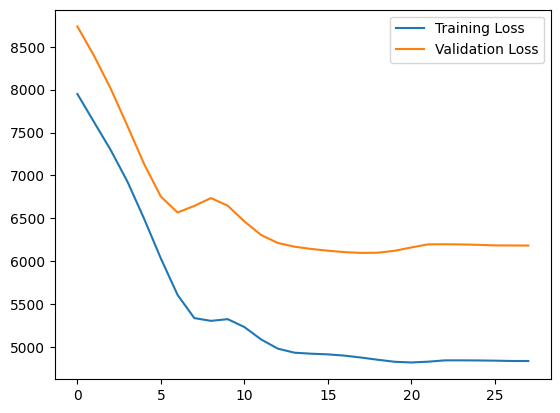

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step


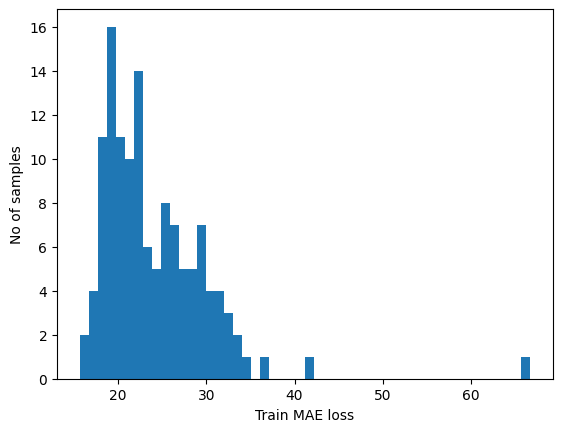

Reconstruction error threshold:  66.72586166675275


In [ ]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# 정상 테스트 데이터
X_test_normal

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
209,52,108,233,147,0.1,3,1,4,1,0,0,1,7
215,65,140,417,157,0.8,1,0,3,1,2,0,1,3
265,54,140,239,160,1.2,0,1,4,0,0,0,1,3
124,48,122,222,186,0.0,0,1,4,0,2,0,1,3
193,48,124,255,175,0.0,2,1,3,1,0,0,1,3
68,69,160,234,131,0.1,1,1,1,1,2,0,2,3
201,51,130,256,149,0.5,0,0,3,0,2,0,1,3
119,71,112,149,125,1.6,0,0,4,0,0,0,2,3
200,44,120,263,173,0.0,0,1,2,0,0,0,1,7
266,35,122,192,174,0.0,0,1,2,0,0,0,1,3


In [ ]:
# 정상 테스트 데이터의 예측 값
X_test_normal_pred = pd.DataFrame(model.predict(X_test_normal), columns=X_test_normal.columns)
X_test_normal_pred

1/1 [==============================] - 0s 45ms/step


,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
0,38.972694,123.862801,0.0,163.823303,0.0,0.0,0.0,0.0,4.260355,0.0,0.0,0.0,0.0
1,60.904110,191.269516,0.0,253.811234,0.0,0.0,0.0,0.0,5.876359,0.0,0.0,0.0,0.0
2,42.212730,135.060104,0.0,178.325317,0.0,0.0,0.0,0.0,4.990451,0.0,0.0,0.0,0.0
3,40.363777,130.812515,0.0,172.261398,0.0,0.0,0.0,0.0,5.496553,0.0,0.0,0.0,0.0
4,43.424709,139.580902,0.0,184.150711,0.0,0.0,0.0,0.0,5.439347,0.0,0.0,0.0,0.0
5,41.802116,131.662415,0.0,174.393295,0.0,0.0,0.0,0.0,4.016582,0.0,0.0,0.0,0.0
6,42.788055,136.290359,0.0,180.139633,0.0,0.0,0.0,0.0,4.805977,0.0,0.0,0.0,0.0
7,29.473913,92.811142,0.0,122.948174,0.0,0.0,0.0,0.0,2.775409,0.0,0.0,0.0,0.0
8,43.843895,141.078659,0.0,186.088562,0.0,0.0,0.0,0.0,5.561158,0.0,0.0,0.0,0.0
9,36.484772,119.383499,0.0,156.874390,0.0,0.0,0.0,0.0,5.436568,0.0,0.0,0.0,0.0


In [ ]:
# 비정상 테스트 데이터
df_abnormal
X_test_abnormal = df_abnormal.drop("num", axis=1)
X_test_abnormal

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
3,58,120,284,160,1.8,0,1,2,0,2,0,2,3
5,50,140,233,163,0.6,1,1,3,0,0,0,2,7
6,61,145,307,146,1.0,0,0,4,0,2,1,2,7
8,70,160,269,112,2.9,1,1,3,0,0,1,2,7
9,66,112,212,132,0.1,1,1,4,0,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,68,144,193,141,3.4,2,1,4,1,0,0,2,7
289,60,158,305,161,0.0,0,0,4,0,2,0,1,3
291,67,100,299,125,0.9,2,1,4,0,2,1,2,3
292,57,140,241,123,0.2,0,0,4,0,0,1,2,7


In [ ]:
# 정상 테스트 데이터의 예측 값
X_test_abnormal_pred = pd.DataFrame(model.predict(X_test_abnormal), columns=X_test_abnormal.columns)
X_test_abnormal_pred

5/5 [==============================] - 0s 3ms/step


,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
0,45.552696,144.680511,0.0,191.381470,0.0,0.0,0.0,0.0,4.966950,0.0,0.0,0.0,0.0
1,41.766678,133.977081,0.0,176.796341,0.0,0.0,0.0,0.0,5.084108,0.0,0.0,0.0,0.0
2,49.348946,154.717270,0.0,205.330856,0.0,0.0,0.0,0.0,4.580657,0.0,0.0,0.0,0.0
3,44.903004,138.196472,0.0,184.262177,0.0,0.0,0.0,0.0,3.101700,0.0,0.0,0.0,0.0
4,36.394848,114.607948,0.0,151.862427,0.0,0.0,0.0,0.0,3.493303,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,37.069279,117.229195,0.0,155.144577,0.0,0.0,0.0,0.0,3.749750,0.0,0.0,0.0,0.0
133,50.433594,160.021133,0.0,211.670609,0.0,0.0,0.0,0.0,5.420111,0.0,0.0,0.0,0.0
134,44.575680,137.837250,0.0,183.652557,0.0,0.0,0.0,0.0,3.392970,0.0,0.0,0.0,0.0
135,41.012955,128.945343,0.0,170.931244,0.0,0.0,0.0,0.0,3.878997,0.0,0.0,0.0,0.0


# 최종 결과 Max Threshold 사용

In [ ]:
threshold = np.max(train_mae_loss)

# 비정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_abnormal['MAE'] = np.mean(np.abs(X_test_abnormal_pred - X_test_abnormal.reset_index(drop=True)), axis=1).tolist()
X_test_abnormal['Result'] = X_test_abnormal['MAE'].apply(lambda x: "Normal" if x< threshold else "Abnomal")
# 정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_normal['MAE'] = np.mean(np.abs(X_test_normal_pred - X_test_normal.reset_index(drop=True)), axis=1).tolist()
X_test_normal['Result'] = X_test_normal['MAE'].apply(lambda x: "Normal" if x< threshold else "Abnomal")

In [ ]:
# 정상 테스트 8개 중 8개를 정상으로 판단
X_test_normal['Result'].value_counts()

Normal    32
Name: Result, dtype: int64

In [ ]:
# 비정상 테스트 137개 중 137개를 정상으로 판단
X_test_abnormal['Result'].value_counts()

Normal    137
Name: Result, dtype: int64

# 최종 결과 3rd Quantile 사용

In [ ]:
# Get reconstruction loss threshold.
threshold = np.percentile(train_mae_loss,0.75)

In [ ]:
# 정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_normal['MAE'] = np.mean(np.abs(X_test_normal_pred - X_test_normal.reset_index(drop=True)), axis=1).tolist()
X_test_normal['Result'] = X_test_normal['MAE'].apply(lambda x: "Normal" if x< threshold else "Abnomal")

# 비정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_abnormal['MAE'] = np.mean(np.abs(X_test_abnormal_pred - X_test_abnormal.reset_index(drop=True)), axis=1).tolist()
X_test_abnormal['Result'] = X_test_abnormal['MAE'].apply(lambda x: "Normal" if x< threshold else "Abnomal")

In [ ]:
# 정상 테스트 8개 중 8개를 정상으로 판단
X_test_normal['Result'].value_counts()

Abnomal    32
Name: Result, dtype: int64

In [ ]:
# 비정상 테스트 137개 중 1 정상으로 136개를 비정상으로 판단
X_test_abnormal['Result'].value_counts()

Abnomal    136
Normal       1
Name: Result, dtype: int64